# 1 Abstract

Gradient Boosting algorithms are considered to be very effective in solving both regression and classification problems. Due to the fact they are both fast and effective, they are often used as a tool to solve Supervised Machine Learning problems. However, well-known advanced techniques, such as XGBoost, CatBoost, and LightGBM come from simple Decision Trees. These are all the development of a single idea. People created advanced modifications for simple algorithms to resolve several issues. In this project, I want to clarify the disadvantages of earlier developed algorithms, showing their performance on real example. Moreover, we will compare the efficiency of algorithms in terms of time and accuracy

# 2 Brief description of the project

### 2.1 Dataset 

It was taken from Kaggle (https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries) and represents salaries of DS specialists in different countires based on several features (including grade, size of company, etc.). It has relatively small number of rows, but its quality is very good (there are no nan-values)

### 2.2 Plan

At first, we will do feature engineering and feature selection. I usually do both at the same time, so we will call it preprocessing. After the table is suitable for the model creation, we will start doing ML-part. Using K-Fold Cross-Validation, we will choose best model (among Decision Tree, Random Forest, AdaBoost, XGBoost, CatBoost, and LightGBM) for our data, as well as discuss pros and cons of these algorithms. We deal with a regression problem, since we want to predict the salary of a specialist, given his features. The comparison metrics will be R squared, since it shows how well the model captures our data, and time it takes to train the model 

### 2.3 One important thing before we start

The algorithms we will be looking at have many parameters, but we will be running them with default ones. Here I do not have a goal to get as high R squared as possible, especially since the dataset is not created for this goals. The thing I care about is comparison of very popular tree-based algorithms in terms of speed and accuracy, as well as discussing all of them in a nutshell

# 3 Data Preprocessing 

### 3.1 Reading the dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('ds_salaries.csv')
df = df.iloc[:, 1:]
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [3]:
#print(df.isnull().sum())
# There are no nan-values

In [4]:
# We are looking only for salary in USD
df = df.drop(['salary', 'salary_currency'], axis = 1)
df.index = np.arange(0, len(df))
#df

### 3.2 Substitution / getting rid of unpopular values

In [5]:
print(df['employment_type'].value_counts())

FT    588
PT     10
CT      5
FL      4
Name: employment_type, dtype: int64


As we see, mainly people work full-time, so it is reasonable to make prediction for people working full-time, as for other types we do not have enough values to make a sample representative

In [6]:
df = df[df['employment_type'] == 'FT']
df = df.drop('employment_type', axis = 1)
df.index = np.arange(0, len(df))

In [7]:
df['remote_ratio'] = df['remote_ratio'] / 100
#normalise value to range from 0 to 1
#df

###### 3.2.1 
Now for columns 'employee_residence', 'job_title', 'company_location' we will substitute values that show up only once (for 'other'), since these are categorical values and there will be too much non needed columns while we will be doing One Hot Encoding

In [8]:
#print(df['employee_residence'].value_counts())

In [9]:
print(df['job_title'].value_counts())

Data Scientist                              140
Data Engineer                               129
Data Analyst                                 96
Machine Learning Engineer                    41
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Director of Data Science                      7
Data Analytics Manager                        7
Machine Learning Scientist                    7
Data Science Consultant                       7
Lead Data Engineer                            6
BI Data Analyst                               6
Principal Data Scientist                      6
Applied Data Scientist                        5
AI Scientist                                  5
Head of Data                                  5
Data Engineering Manager                      5
Head of Data Science                          4
Analytics Engineer                      

In [10]:
res_stats = df.groupby('employee_residence')['employee_residence'].agg('count').sort_values(ascending = False)
res_stats
res_stats_less_than_2 = res_stats[res_stats < 2]
df.employee_residence = df.employee_residence.apply(lambda x: 'other' if x in res_stats_less_than_2 else x)
#len(df.employee_residence.unique())

job_stats = df.groupby('job_title')['job_title'].agg('count').sort_values(ascending = False)
job_stats
job_stats_less_than_2 = job_stats[job_stats < 2]
df.job_title = df.job_title.apply(lambda x: 'other' if x in job_stats_less_than_2 else x)
#len(df.job_title.unique())

location_stats = df.groupby('company_location')['company_location'].agg('count').sort_values(ascending = False)
location_stats
location_stats_less_than_2 = location_stats[location_stats < 2]
df.company_location = df.company_location.apply(lambda x: 'other' if x in location_stats_less_than_2 else x)
#len(df.company_location.unique())

### 3.3 Time problem

There are observations for 2020, 2021, and 2022 years. There is no point in predicting salaries for any period of time, which is earlier than 2022. An assumption that salaries are increasing in time seems reasonable. So I propose to approximate what would be the salaries for 2020 and 2021 in 2022. We will not spend significant amount of time working on time series, since this is not what I want to do in this project. A rather simple approach is to look at the median and mean relationships and come up with reasonable multiples for 2020 and 2021 salaries

In [11]:
df1 = df[df['work_year'] == 2020]
df2 = df[df['work_year'] == 2021]
df3 = df[df['work_year'] == 2022]
a1 = df1['salary_in_usd'].median()
a2 = df2['salary_in_usd'].median()
a3 = df3['salary_in_usd'].median()

a = df1['salary_in_usd'].mean()
b = df2['salary_in_usd'].mean()
c = df3['salary_in_usd'].mean()

print(b / a)
print('')
print(c / b)
print('')
print(a3 / a2)
print('')
print(a2 / a1)

1.020067779524499

1.2454691040557397

1.4127058823529413

1.0842459069717012


In this context, it is better to underestimate than to overestimate. Coefficients equal to 1.05 and 1.25 for 2020 and 2021 years respectively seem fine for me. Note that we do not convert values from 2020 to 2022 directly. There is an intermediate step - to convert 2020 to 2021 at first

In [12]:
for i in range(len(df)):
  if df['work_year'][i] == 2020:
    df['work_year'][i] = 2021
    df['salary_in_usd'][i] = df['salary_in_usd'][i] * 1.05
for i in range(len(df)):
  if df['work_year'][i] == 2021:
    df['work_year'][i] = 2022
    df['salary_in_usd'][i] = df['salary_in_usd'][i] * 1.25

df = df.drop('work_year', axis = 1)
# since work year is now the same for each observation, we no longer need it as a feature
df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,MI,Data Scientist,104780,DE,0.0,DE,L
1,SE,Machine Learning Scientist,341250,JP,0.0,JP,S
2,SE,Big Data Engineer,143093,GB,0.5,GB,M
3,MI,Product Data Analyst,26250,other,0.0,other,S
4,SE,Machine Learning Engineer,196875,US,0.5,US,L
...,...,...,...,...,...,...,...
583,SE,Data Engineer,154000,US,1.0,US,M
584,SE,Data Engineer,126000,US,1.0,US,M
585,SE,Data Analyst,129000,US,0.0,US,M
586,SE,Data Analyst,150000,US,1.0,US,M


### 3.4 Dealing with outliers

Since many models are sensitive to outliers (however, tree-based models are not as sensitive as continuous ones), it is always better to remove them. However, our dataset is rather small, so we do not want to loose observations. That is why, instead of removing outliers, we will substitute values which exceed 99th percentile to 99th percentile itself, and we will substitute values which are below 1st percentile to 1st percentile itself

In [13]:
df['salary_in_usd'] = df['salary_in_usd'].clip(lower=df['salary_in_usd'].quantile(0.01), upper=df['salary_in_usd'].quantile(0.99))

### 3.5 Is remote ratio an informative feature?

I am not sure about that. However, since this value is a float one, we can check the correlation matrix

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

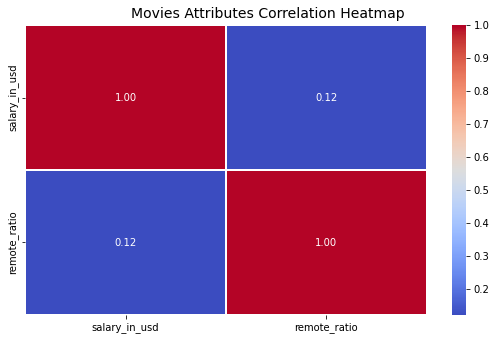

In [15]:
f, ax = plt.subplots(figsize = (10, 6))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot = True, ax = ax, cmap = "coolwarm", fmt = '.2f', linewidths = .05)
f.subplots_adjust(top = .93)
t= f.suptitle('DS salaries correlation Heatmap', fontsize = 14)
plt.gcf().set_size_inches(9, 5)

0.12 is a very small number for correlation, so it is better to delete this feature

In [16]:
df = df.drop('remote_ratio', axis = 1)
df

,experience_level,job_title,salary_in_usd,employee_residence,company_location,company_size
0,MI,Data Scientist,104780.0,DE,DE,L
1,SE,Machine Learning Scientist,341250.0,JP,JP,S
2,SE,Big Data Engineer,143093.0,GB,GB,M
3,MI,Product Data Analyst,26250.0,other,other,S
4,SE,Machine Learning Engineer,196875.0,US,US,L
...,...,...,...,...,...,...
583,SE,Data Engineer,154000.0,US,US,M
584,SE,Data Engineer,126000.0,US,US,M
585,SE,Data Analyst,129000.0,US,US,M
586,SE,Data Analyst,150000.0,US,US,M


### Here is the final version of our DataFrame and now we are able to construct models

# 4 Model construction

### 4.1 CatBoost

Despite it is the newest and one of the most advanced algorithms among those I will use here, I want to start with it to show its awesome advantage - it perfectly deals with categorical features. We do not need to do One Hot Encoding - there is just a need to specify those categorical columns

In [17]:
from catboost import CatBoostRegressor, Pool

x = df.drop(columns = 'salary_in_usd')
y = df['salary_in_usd']
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as RSquared
accuracy = []
for i in range(5):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
  pool_train = Pool(x_train, y_train, cat_features = ['experience_level', 'job_title', 'employee_residence', 'company_location', 'company_size'])
  pool_test = Pool(x_test, cat_features = ['experience_level', 'job_title', 'employee_residence', 'company_location', 'company_size'])
  model = CatBoostRegressor()
  model.fit(pool_train, metric_period = 100)
  y_pred = model.predict(x_test)
  cb_rsquared = np.sqrt(RSquared(y_test, y_pred))
  accuracy.append(np.mean(cb_rsquared))
print('Scores that we got: ', accuracy)

Learning rate set to 0.036339
0:	learn: 73287.4815089	total: 48.7ms	remaining: 48.6s
100:	learn: 46667.7573056	total: 268ms	remaining: 2.39s
200:	learn: 41960.8670770	total: 629ms	remaining: 2.5s
300:	learn: 38090.4989242	total: 879ms	remaining: 2.04s
400:	learn: 35633.6436371	total: 1.09s	remaining: 1.64s
500:	learn: 33575.3607506	total: 1.32s	remaining: 1.31s
600:	learn: 31672.5754540	total: 1.55s	remaining: 1.03s
700:	learn: 29999.9384346	total: 1.75s	remaining: 745ms
800:	learn: 28530.5874357	total: 1.96s	remaining: 487ms
900:	learn: 27100.3631403	total: 2.17s	remaining: 239ms
999:	learn: 25917.7375906	total: 2.53s	remaining: 0us
Learning rate set to 0.036339
0:	learn: 71314.7216600	total: 1.03ms	remaining: 1.03s
100:	learn: 46537.5006766	total: 327ms	remaining: 2.91s
200:	learn: 42418.2577221	total: 755ms	remaining: 3s
300:	learn: 39666.5122786	total: 1.38s	remaining: 3.2s
400:	learn: 37149.7644242	total: 2.02s	remaining: 3.01s
500:	learn: 35196.4949139	total: 2.44s	remaining: 2.4

### 4.2 Build dataset for other models

Now we will do One Hot Encoding using built-in pandas method to get dummies 

In [18]:
x = df.drop(columns = 'salary_in_usd')
y = df['salary_in_usd']
dummies1 = pd.get_dummies(data = x, columns = ['experience_level', 'job_title', 'employee_residence', 'company_location', 'company_size'])
x = pd.concat([x.drop(['experience_level', 'job_title', 'employee_residence', 'company_location', 'company_size'], axis = 'columns'), dummies1], axis = 'columns')
x

,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,job_title_AI Scientist,job_title_Analytics Engineer,job_title_Applied Data Scientist,job_title_Applied Machine Learning Scientist,job_title_BI Data Analyst,job_title_Big Data Engineer,...,company_location_PL,company_location_PT,company_location_RU,company_location_SI,company_location_TR,company_location_US,company_location_other,company_size_L,company_size_M,company_size_S
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
584,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
585,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
586,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### 4.3 One more important thing before we start

We will run each algorithm with default parameters since in this project I do not want to show how to search for best parameters. It can be done using GridSearchCV or Randomized one, but we will do it in on of the next projects, where the goal will be to build a model Pipeline. Here the goal is to compare algorithms in very general ways. We will use 5-Fold Cross-Validation to get more metrics on the one hand, and to make each data point be a trainer for our model, on the other hand (it is useful since the dataset is small)

### 4.4 Decision Tree

This is the first algorithm in our evolution chain. Trees by themselves are weak learner. By combining them, we reduce bias or variance of the algoritm, making models better. So, whatever Boosting or Bagging techniques you use, the basis is always the simplest Decision Tree method. The advantage of this algorithm is that it is very clear, fast, easy to interpret, and can even be plotted. We will see that already the next step in our evolution chain - Random Forest algorithm, is a black box, requiring much more memory and time. However, despite all the advantages of the Decision Tree - it is usually a bad method to use

In [19]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from time import time
start = time()
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
print('Scores that we got: ', cross_val_score(DecisionTreeRegressor(), x, y, cv=cv))
speed = np.round(time() - start, 3)
print('')
print('Total time spent is: ', speed, ' seconds')

Scores that we got:  [0.32194514 0.15085106 0.39171894 0.19535009 0.40410197]

Total time spent is:  0.047  seconds


We see that sometimes we get score around 0.4, sometimes - around 0.15. The difference is twice, therefore, our model is very likely to be overfitted, since the variance is high. This problem is common for Decision Trees, and usually to reduce high variance we use Bagging techniques. The most common among them is Random Forest

### 4.5 Random Forest

Now we will generate many trees and combine their individual predictions to make a final prediction

In [20]:
from sklearn.ensemble import RandomForestRegressor
start = time()
print('Scores that we got: ', cross_val_score(RandomForestRegressor(), x, y, cv=cv))
speed = np.round(time() - start, 3)
print('')
print('Total time spent is: ', speed, ' seconds')

Scores that we got:  [0.50227712 0.45193167 0.48740914 0.43770008 0.53247057]

Total time spent is:  1.545  seconds


We see that both variance and bias were reduced. That is why, Random Forest is considered much better than simple Tree. However, there is a more efficient approach - to learn from mistakes the previous trees made while creating new ones. So now our model will be built sequentionally (not parallely) and we will take into account mistakes we made in past in order not to make them be made one more time. Probably the simplest boosting tecnique is AdaBoost

### 4.6 AdaBoost

The advantage of this model is that it is usually not overfitted since we use the simplest possible trees (stumps) to train it. That is why, usually there is no need to do hyperparameter tuning. Based on the amount of right and wrong predictions each tree gets certain amount of say (how strongly will its voice influence the decision) and each time observations which were incorrectly classified will be chosen with higher probability in future samples for stumps constructions

In [21]:
from sklearn.ensemble import AdaBoostRegressor
start = time()
print('Scores that we got: ', cross_val_score(AdaBoostRegressor(), x, y, cv=cv))
speed = np.round(time() - start, 3)
print('')
print('Total time spent is: ', speed, ' seconds')

Scores that we got:  [0.41722433 0.29374663 0.45282977 0.33895643 0.47362551]

Total time spent is:  0.367  seconds


### 4.7 XGBoost

We will not use the typical Gradient Boosting since I do not see any point in it (unless you are doing ML within the tool having no XGBoost such as PySpark). It is slower, less efficient, and there is no regularization. However, the tool is still powerful and it is definetely worth using against Decision Tree and AdaBoost (at least most of the time). The point is that there is no point in it if there exist the extreme versions, which are better. Remember one of my last projects - where we found out there is no need to use Gradient Descent when we have SGD. At the same time, even batch GD is a very powerful tool. However, within the development of algorithms people develop more efficient approaches which help us save time with no loss in accuracy or even gain in it

As for XGBoost, now we will learn from past mistakes not by making sample changes, but by optimizing the function with the help of Gradient Descent. At the same time, we will avoid overfitting by doing pruning - the Gain must be high enough to allow model expand trees. Also there will be a regularization term that will decrease the Similarity Score at each iteration, therefore, making pruning more strict

In [22]:
import xgboost as xgb
start = time()
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
print('Scores that we got: ', cross_val_score(xgb.XGBRegressor(), x, y, cv=cv))
speed = np.round(time() - start, 3)
print('')
print('Total time spent is: ', speed, ' seconds')

[19:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Scores that we got:  [0.52750133 0.45596996 0.52849607 0.50601674 0.53957701]

Total time spent is:  0.709  seconds


### 4.8 LightGBM

Microsoft made some changes with ordinary XGBoost to make this algorithm. It is usually faster than XGBoost because of the special tree structure (we will talk about it later)

In [23]:
import lightgbm
start = time()
print('Scores that we got: ', cross_val_score(lightgbm.LGBMRegressor(), x, y, cv=cv))
speed = np.round(time() - start, 3)
print('')
print('Total time spent is: ', speed, ' seconds')

Scores that we got:  [0.55249826 0.49637498 0.56525891 0.55007497 0.58339586]

Total time spent is:  0.163  seconds


# 5 Interpretation of the results

### 5.1 Accuracy

CatBoost definetely outperformed everybody. LightGBM and XGBoost share second and third places respectively (LightGBM is somewhere around 55 percent accuracy, while XGBoost - around 50 percent accuracy). Random Forest works fine, while AdaBoost and Decision Tree show unsatisfying results, in my view

### 5.2 Variance

I find Decision Tree, AdaBoost and CatBoost as overfitted, while others are fine in these terms. I determined this by comparing the cross-validation ranges. I was surprised by AdaBoost and CatBoost, since AdaBoost is a relatively simple model, while CatBoost uses advanced techniques to reduce variance

### 5.3 Time

It is obvious that Tree is the winner because the algorithm is very simple to train. As for others, CatBoost is the slowest and it is significantly slower than others. The main explanation is that it does 1000 iterations by default, even if it is not needed. Maybe this is the explanation of overfitting, since we know that models start to overtrain ones we have more iterations than necessary. However, we will not change the parameters in this project. As it was expected, LightGBM is very good at time, and the accuracy is relatively well also. XGBoost is approximately twice faster than Random Forest, although the accuracy is better

The metric of time here is not important, since the dataset is very small and has just a few features. It does not matter if we train a one minute more, if this results in a higher accuracy. For this reasons, CatBoost definetely performed the best, and Tree - the worst, despite they are absolute loser and winner in terms of speed respectively

### 5.4 Best algorithms for this particular case (which and why)

I already explained why we are not looking at speed while exploring the best algorithm for this problem. That is why we will look at accuracy. Since CatBoost is the leader, and LightGBM and XGBoost are not overfitted, these will be our winners

### 5.5 Algorithms which gave unsatisfying results (which and why)

I am not pleased with Tree and AdaBoost since they have both high bias and high variance (compared to other algorithms)

# 6 XGBoost vs CatBoost vs LightGBM

These 3 algortihms can be considered as the most powerful classical statistical ML methods. Their strength can sometimes outperform even Deep Learning methods. That is why, there is a frequent question - which one is better? In order to see why there is no clear answer, let's compare them:



### 6.1 How the Decision Tree is created?

In XGBoost the Decision Tree is the ordinary one; In CatBoost the Tree is symmetric (nodes at the same level split at the same condition); In LightGBM the Tree is leaf-wise (only one leaf grow throughout iteration, and we choose a leaf that maximises the additional Gain). We cannot say which option is the best one, it depends on the use case

### 6.2 Categorical variables

We saw that CatBoost perfectly deals with these variables; as for XGBoost, we will have to do one-hot encoding. In LightGBM there is a special technique, but, according to my observations, CatBoost is the most powerful in these terms

### 6.3 Speed

LightGBM is the winner in most of the cases. As for XGBoost and CatBoost, it is harder to say. Here the XGBoost was an absolute winner, while some researchers claim that CatBoost can be several times faster on big data because of the special Tree design. Also, there are many parameters to play with, which affect speed much

### 6.4 When to use?

###### This is just my opinion and I say it accroding to the literature and materials I studied, as well as my own experience

CatBoost is probably the best option when we deal with many categorical features (I have seen at least few datasets which fully consist of them). In this situation, CatBoost will save a lot of time and the code will be more attractive and easy to understand

LightGBM is great when we do not want to spend much time on the task. We are sure that whatever the situation is, we can somehow handle categorical features, the speed will be just fine, and the accuracy will be good enough

XGBoost is useful when accuracy matters, as well as the community support. This algorithm has proven itself many times for many years. It is liked by both Kaggle competition winners, academic researchers, and industrial Data Scientists